In [1]:
#importamos algunas librerias necesarias...
import os
import random
import numpy as np
from dataclasses import dataclass, field
from typing import Optional, Dict, Any


In [2]:
# Configuramos semillas para reproducibilidad de resultados:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [3]:
# Hiperparámetros del modelo:
EPOCHS = 1 # Número de épocas de entrenamiento
BATCH_SIZE = 8 # Tamaño del lote para entrenamiento
LR = 2e-5
MAX_LEN = 64 # Longitud máxima de tokens por texto
OUTPUT_DIR = "outputs_task2" # Directorio para guardar resultados
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Modelos base (los que utilizamos para preentrenar)
MODEL_ROBERTA = "roberta-base"
MODEL_DEBERTA = "microsoft/deberta-v3-base"
MODERN_BERT_CHECKPOINT = "bert-base-uncased"


In [4]:
# Dependencias
# Importa librerías para cargar datasets, usar modelos de transformers, manejar tensores con torch,
# calcular métricas con scikit-learn y manipular datos con pandas.
from datasets import load_dataset, ClassLabel, DatasetDict, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from sklearn.metrics import f1_score, accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#Cargamos AG News
dataset = load_dataset("ag_news")  # train=120000, test=7600


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [6]:
# Combinamos train y test para hacer división personalizada 70/15/15
combined = concatenate_datasets([dataset["train"], dataset["test"]])
combined = combined.shuffle(seed=SEED) #mezclamos aleatoriamente
total_n = len(combined)
train_n = int(0.70 * total_n) # 70% para entrenamiento
val_n = int(0.15 * total_n) # 15% para validación
test_n = total_n - train_n - val_n # 15% para prueba

# Creamos  los splits:

train_ds = combined.select(range(0, train_n))
val_ds = combined.select(range(train_n, train_n + val_n))
test_ds = combined.select(range(train_n + val_n, total_n))

# Creamos diccionario de datasets:

agnews = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds
})

In [7]:
# Distribución de etiquetas: contamos la frecuencia de cada etiqueta en el dataset
def label_counts(ds):
    df = ds.to_pandas()
    return df['label'].value_counts().sort_index()
print("Label counts train:", label_counts(agnews["train"]).to_dict())

# Funciones de tokenización: para cada modelo en especifico y tokeniza un lote de textos
def prepare_tokenizer(checkpoint):
    return AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

def tokenize_batch(example, tokenizer):
    return tokenizer(example['text'], truncation=True, padding=False, max_length=MAX_LEN)


Label counts train: {0: 22314, 1: 22452, 2: 22285, 3: 22269}


In [8]:
# Función de entrenamiento y evaluación
def train_and_eval(model_checkpoint, dataset_dict, model_name_tag):
    print(f"\n=== Entrenando {model_name_tag} ({model_checkpoint}) ===")

    # Tokenizador
    tokenizer = prepare_tokenizer(model_checkpoint)
    tokenized = dataset_dict.map(lambda x: tokenize_batch(x, tokenizer), batched=True, remove_columns=['text'])
    tokenized = tokenized.map(lambda x: {'labels': x['label']}, batched=True)

    # Modelo preentrenado para clasificación con 4 clases...
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=4)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # TrainingArguments unificado
    training_args = TrainingArguments(
        output_dir=os.path.join(OUTPUT_DIR, model_name_tag),
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        seed=SEED,
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        report_to="none"  # desactiva W&B
    )

    # Cálculo de métricas
    def compute_metrics(pred):
        preds = np.argmax(pred.predictions, axis=1)
        labels = pred.label_ids
        f1_macro = f1_score(labels, preds, average='macro')
        f1_weighted = f1_score(labels, preds, average='weighted')
        acc = accuracy_score(labels, preds)
        return {"accuracy": acc, "f1_macro": f1_macro, "f1_weighted": f1_weighted}

    # Iniciamos trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["validation"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    # Entrenamiento del modelo
    trainer.train()

    # Evaluación final en test set
    test_tokenized = tokenized["test"]
    preds_output = trainer.predict(test_tokenized)
    preds = np.argmax(preds_output.predictions, axis=1)
    true = preds_output.label_ids

    #calculamos métricas finales:

    f1_macro = f1_score(true, preds, average='macro')
    f1_weighted = f1_score(true, preds, average='weighted')
    acc = accuracy_score(true, preds)

    # generamos reporte de clasificación detallaodo..

    report = classification_report(true, preds, target_names=["World","Sports","Business","Sci/Tech"], digits=4)

    #diccionario de resultados..

    results = {
        "model": model_name_tag,
        "checkpoint": model_checkpoint,
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted
    }

    # Guardamos los resultados:
    pd.DataFrame({"true": true, "pred": preds}).to_csv(os.path.join(OUTPUT_DIR, f"preds_{model_name_tag}.csv"), index=False)
    with open(os.path.join(OUTPUT_DIR, f"metrics_{model_name_tag}.txt"), "w") as f:
        f.write(str(results) + "\n\n")
        f.write(report)

    return results


In [9]:
# Ejecutamos entrenamiento para todos los modelos:

#Lista de modelos a entrenar:

models_to_run = [
    (MODEL_ROBERTA, "roberta_base"),
    (MODEL_DEBERTA, "deberta_v3_base"),
    (MODERN_BERT_CHECKPOINT, "modern_bert")
]

#Entrenamos cada modelo y guardamos los resultados:

all_results = []
for ckpt, tag in models_to_run:
    res = train_and_eval(ckpt, agnews, tag)
    print(res)
    all_results.append(res)



=== Entrenando roberta_base (roberta-base) ===


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-356825583.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.224400,0.223808,0.942633,0.942818,0.942623


{'model': 'roberta_base', 'checkpoint': 'roberta-base', 'accuracy': 0.9427377220480668, 'f1_macro': 0.9429868332840208, 'f1_weighted': 0.9427710357554164}

=== Entrenando deberta_v3_base (microsoft/deberta-v3-base) ===


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-356825583.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.220500,0.231546,0.940439,0.940565,0.940397


{'model': 'deberta_v3_base', 'checkpoint': 'microsoft/deberta-v3-base', 'accuracy': 0.9393939393939394, 'f1_macro': 0.9395944427549203, 'f1_weighted': 0.9393526625583689}

=== Entrenando modern_bert (bert-base-uncased) ===


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/89320 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

Map:   0%|          | 0/19140 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-356825583.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.206700,0.207883,0.943051,0.943275,0.943085


{'model': 'modern_bert', 'checkpoint': 'bert-base-uncased', 'accuracy': 0.9408045977011494, 'f1_macro': 0.9410525701018884, 'f1_weighted': 0.9408276923476184}


             model  accuracy  f1_macro  f1_weighted
0     roberta_base  0.942738  0.942987     0.942771
1  deberta_v3_base  0.939394  0.939594     0.939353
2      modern_bert  0.940805  0.941053     0.940828


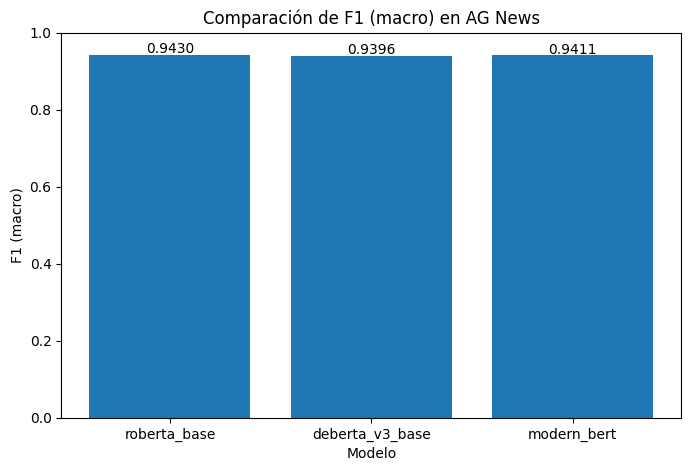


✅ Entrenamiento completo. Resultados guardados en: outputs_task2


In [10]:
# Resultados y visualización

#Convertimos los resultados a dataframes:

df_res = pd.DataFrame(all_results)
print(df_res[["model","accuracy","f1_macro","f1_weighted"]])

#Creamos gráfico de barras comparando F1-Macro

plt.figure(figsize=(8,5))
plt.bar(df_res['model'], df_res['f1_macro'])
plt.ylabel("F1 (macro)")
plt.xlabel("Modelo")
plt.title("Comparación de F1 (macro) en AG News")

# Añadir valores sobre las barras

for i, v in enumerate(df_res['f1_macro']):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')
plt.ylim(0,1)
plt.savefig(os.path.join(OUTPUT_DIR, "f1_macro_comparison.png"), dpi=150)
plt.show()

# Guardar resumen de resultados

df_res.to_csv(os.path.join(OUTPUT_DIR, "summary_results.csv"), index=False)
print("\n✅ Entrenamiento completo. Resultados guardados en:", OUTPUT_DIR)



In [11]:
#Bonus Task — Clasificación de 50 artículos RPP usando LLM y modelos entrenados

import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [13]:
#Cargar CSV de 50 artículos RPP
from google.colab import files
import pandas as pd  # Para leer el CSV

# Subimos el archivo de la carpeta src rpp_articles_raw_clean:
uploaded = files.upload()

Saving rpp_articles_raw_clean.csv to rpp_articles_raw_clean.csv


In [14]:
import pandas as pd

filename = list(uploaded.keys())[0]

#Intentamos leer el archivo con diferentes configuraciones
#1er intento: con encoding y separador automático
rpp_df = pd.read_csv(filename, encoding='utf-8', sep=None, engine='python')

# revisamos las primeras líneas
with open(filename, 'r', encoding='utf-8') as f:
    for _ in range(5):
        print(f.readline())


﻿title;description;link;date_published

Nicolás Maduro anuncia nuevos ejercicios militares en las costas de Venezuela por 72 horas;"Maduro sostuvo que a la medianoche de este jueves llamó a ""quienes tenía que llamar"" y dio la orden de activar todos los equipos militares ""de inmediato"" para la defensa de los ""puntos de acción"" en t...";https://rpp.pe/mundo/actualidad/nicolas-maduro-anuncia-nuevos-ejercicios-militares-en-las-costas-de-venezuela-por-72-horas-noticia-1660705;2025-10-23T22:47:59

Latin Billboard 2025: lista completa de nominados, con Bad Bunny, Karol G y Rauw Alejandro entre los favoritos;En esta edición, Bad Bunny encabeza las nominaciones con 27 categorías, mientras que Fuerza Regida, Rauw Alejandro y Karol G también se perfilan entre los grandes favoritos....;https://rpp.pe/musica/internacional/latin-billboard-2025-lista-completa-de-nominados-de-premios-de-la-musica-latina-noticia-1660621;2025-10-23T22:45:15

Universitario vs. Sporting Cristal hoy EN VIVO: juegan e

In [15]:
rpp_df = pd.read_csv(filename, sep=';', encoding='utf-8')  # dado que el separador es un punto y coma
texts_50 = rpp_df['description'].tolist()


In [20]:
import os
os.listdir("outputs_task2")

['preds_modern_bert.csv',
 'preds_deberta_v3_base.csv',
 'preds_roberta_base.csv',
 'deberta_v3_base',
 'f1_macro_comparison.png',
 'modern_bert',
 'metrics_modern_bert.txt',
 'metrics_roberta_base.txt',
 'metrics_deberta_v3_base.txt',
 'roberta_base',
 'summary_results.csv']

In [22]:
import os

# Verificar las rutas de los modelos
print(os.listdir('outputs_task2/roberta_base'))
print(os.listdir('outputs_task2/deberta_v3_base'))
print(os.listdir('outputs_task2/modern_bert'))


['checkpoint-11165']
['checkpoint-11165']
['checkpoint-11165']


In [23]:
print(os.listdir('outputs_task2/roberta_base/checkpoint-11165'))
print(os.listdir('outputs_task2/deberta_v3_base/checkpoint-11165'))
print(os.listdir('outputs_task2/modern_bert/checkpoint-11165'))

['vocab.json', 'training_args.bin', 'trainer_state.json', 'tokenizer_config.json', 'merges.txt', 'rng_state.pth', 'scheduler.pt', 'model.safetensors', 'tokenizer.json', 'optimizer.pt', 'special_tokens_map.json', 'config.json']
['training_args.bin', 'trainer_state.json', 'tokenizer_config.json', 'rng_state.pth', 'scheduler.pt', 'model.safetensors', 'tokenizer.json', 'added_tokens.json', 'optimizer.pt', 'special_tokens_map.json', 'config.json', 'spm.model']
['training_args.bin', 'trainer_state.json', 'tokenizer_config.json', 'rng_state.pth', 'scheduler.pt', 'model.safetensors', 'vocab.txt', 'tokenizer.json', 'optimizer.pt', 'special_tokens_map.json', 'config.json']


In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Diccionario con las rutas locales de tus modelos guardados
MODEL_DIRS = {
    "roberta_base": "outputs_task2/roberta_base",
    "deberta_v3_base": "outputs_task2/deberta_v3_base",
    "modern_bert": "outputs_task2/modern_bert"
}

# Función para cargar modelo y tokenizer
def get_model_and_tokenizer(path):
    # Buscar automáticamente el subdirectorio del checkpoint
    subdirs = [d for d in os.listdir(path) if d.startswith("checkpoint")]
    if not subdirs:
        raise ValueError(f"No se encontró ningún checkpoint en {path}")

    checkpoint_path = os.path.join(path, subdirs[-1])  # toma el más reciente
    print(f"Cargando modelo desde: {checkpoint_path}")

    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)
    return tokenizer, model

# Carga de modelos y predicción sobre top 50 noticias
for name, path in MODEL_DIRS.items():
    tokenizer, model = get_model_and_tokenizer(path)
    preds = predict_texts(model, tokenizer, texts_50)
    rpp_df[f'pred_{name}'] = preds


Cargando modelo desde: outputs_task2/roberta_base/checkpoint-11165
Cargando modelo desde: outputs_task2/deberta_v3_base/checkpoint-11165
Cargando modelo desde: outputs_task2/modern_bert/checkpoint-11165


F1-score roberta_base vs LLM: 0.4887
F1-score deberta_v3_base vs LLM: 0.4811
F1-score modern_bert vs LLM: 0.3488


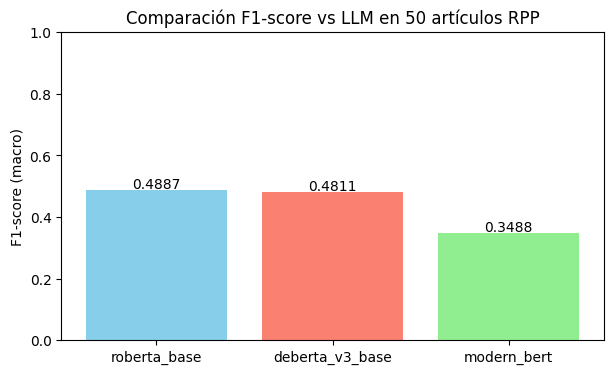

Resultados guardados en RPP_50_Articles_with_model_preds.csv


In [26]:
#Comparar F1-score de cada modelo vs LLM:
f1_scores = {}

# Calcular F1-score de cada modelo vs las etiquetas del LLM

for name in MODEL_DIRS.keys():
    f1 = f1_score(rpp_df['llm_label'], rpp_df[f'pred_{name}'], average='macro')
    f1_scores[name] = f1
    print(f"F1-score {name} vs LLM: {f1:.4f}")

# Visualización:
plt.figure(figsize=(7,4))
plt.bar(f1_scores.keys(), f1_scores.values(), color=['skyblue','salmon','lightgreen'])
plt.ylabel("F1-score (macro)")
plt.title("Comparación F1-score vs LLM en 50 artículos RPP")
for i, v in enumerate(f1_scores.values()):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center')
plt.ylim(0,1)
plt.show()

#Guardar resultados
rpp_df.to_csv("/content/RPP_50_Articles_with_model_preds.csv", index=False)
print("Resultados guardados en RPP_50_Articles_with_model_preds.csv")


In [27]:
import shutil

# Carpeta con todos los outputs
OUTPUT_DIR = "outputs_task2"

# Nombre del archivo zip final
ZIP_NAME = "outputs_task2.zip"

# Crear el zip
shutil.make_archive("outputs_task2", 'zip', OUTPUT_DIR)

# Descargar
from google.colab import files
files.download(ZIP_NAME)


KeyboardInterrupt: 